# STAT778: Homework 5
*Sean Steinle*

## Table of Contents
1. [Inverse Transform Sampling and Metropolis-Hastings](#Inverse-Transform-Sampling-and-Metropolis-Hastings)
    - [Inverse Transform Sampling for G](#Inverse-Transform-Sampling-for-G)
    - [A Valid Envelope](#A-Valid-Envelope)
    - [Rejection Sampling for F](#Rejection-Sampling-for-F)
2. [Gibbs Sampling](#Gibbs-Sampling)

## Inverse Transform Sampling and Metropolis-Hastings

### Inverse Transform Sampling for G

Question 1a asks us to create a sampler for g.
1. We can treat g(x,y|z) as two independent variables g(x|z) and g(y|z).
2. Both g(x|z) and g(y|z) have the same functional form as each other. The only different is that x is distributed from (-inf,inf) while y is distributed from \[0,inf).
3. Both g(x|z) and g(y|z) have the same functional form as the Laplace distribution, where z is the location parameter and diversity is set sqrt(2). Note that g(x|z) amnd g(y|z) are scaled by a factor of 2*sqrt(2).
4. Because we know the Laplace distribution has a closed-form inverse, we can use inverse transform sampling to generate random numbers of the same functional form as g(x|z) and g(y|z).

In [1]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import uniform, normal, laplace
from numpy import sign,linspace
from math import exp, log

In [45]:
def slaplace(z: float = 0, beta: float = 2 ** 0.5): 
    """Generates samples from the Laplace distribution where z is the location parameter and beta is the diversity parameter."""
    u = uniform() #draw u, a float from [0,1]
    sample = z - beta * sign(u - 0.5) * log(1 - 2 * abs(u - 0.5)) #transform u using inverse cdf of the laplace distribution
    return sample * (2*(2**0.5)) #rescale sample

def g(x: float, y: float):
    """Uses our Laplace sampler to sample from g."""
    x = slaplace(x)
    posy = -1
    while posy < 0:
        posy = slaplace(y)
    return x*y

def g_density(x: float, y: float, z: float = 0):
    """Calculates density of g for theta = (x,y). Assume z = 0."""
    return exp(-abs(x-z)/(2**0.5)) - exp(-abs(y-z)/(2**0.5))
    
def f_density(x: float, y: float, z: float = 0): #PROBLEM: this is density!
    """Calculates density of f for theta = (x,y). Assume z = 0."""
    if x>=y: return 0
    return exp(-abs((x-z)*(y-z)) - max(abs(x-z),abs(y-z)))

(array([1.7000e+01, 1.0800e+02, 7.9400e+02, 6.2510e+03, 5.0308e+04,
        3.7255e+04, 4.6040e+03, 5.7800e+02, 7.7000e+01, 8.0000e+00]),
 array([-41.45161773, -33.03152156, -24.61142538, -16.1913292 ,
         -7.77123302,   0.64886316,   9.06895934,  17.48905552,
         25.90915169,  34.32924787,  42.74934405]),
 <BarContainer object of 10 artists>)

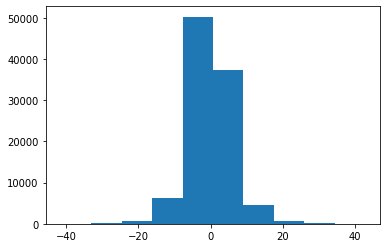

In [3]:
scaled_laplace_samples = [slaplace() for _ in range(100000)]
plt.hist(scaled_laplace_samples, bins = 10)

(array([2.0000e+00, 2.0000e+00, 2.5000e+01, 3.6500e+02, 4.9710e+03,
        5.9789e+04, 3.2252e+04, 2.4000e+03, 1.8600e+02, 8.0000e+00]),
 array([-42.99404253, -35.65707575, -28.32010897, -20.98314219,
        -13.64617541,  -6.30920863,   1.02775816,   8.36472494,
         15.70169172,  23.0386585 ,  30.37562528]),
 <BarContainer object of 10 artists>)

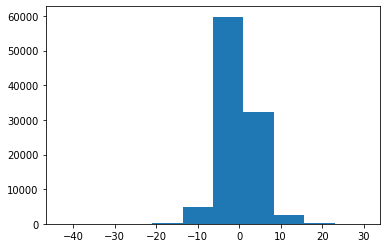

In [4]:
laplace_samples = [laplace(0, 2*(2**0.5)) for _ in range(100000)]
plt.hist(laplace_samples, bins = 10)

In [5]:
slaplace(1)

3.0793344230031656

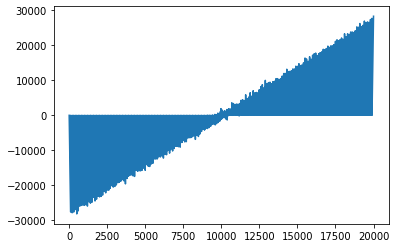

In [6]:
g_samples = [g(x,y) for x in range(-100,100) for y in range(100)]
plt.plot(g_samples)

As a quick sanity check, we can see that our Laplace sampling function generates the same shape as Numpy's Laplace sampler. We can also see a run chart of samples from g().

### A Valid Envelope

Text(0.5, 1.0, 'Domains of F and G')

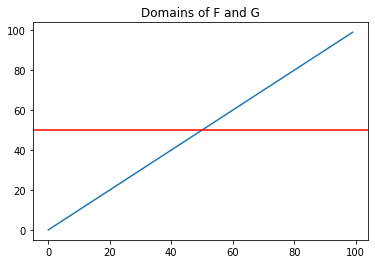

In [7]:
plt.plot(range(100))
plt.axhline(y = 50, color = 'red')
plt.title("Domains of F and G")

prove g majorizes f
prove g's domain is the same as f's domain


To prove that g (or some scaling of g) is a valid envelope for f, we must prove two things: that g's domain spans the domain of f, and that g majorizes.
- g's domain spans the domain of f because g's domain is a rotation of f's domain (as shown in the plot above). g's domain encompasses all real numbers above Y=0, whereas f's domain encompasses all real numbers where X>Y. The bivariate density of f when x = (x-y)/sqrt(2), y = (x+y)/sqrt(2) rotates f's domain such that g spans f's domain.
- exp(abs(z))\*g majorizes f because...
    - if x is further from z than y is...
    - else...
    TD there is some algebra to do here, ask Morgan

POST OFFICE HOURS TO DO LIST:
- 1a
    - treat z as a constant
    - factorize X and Y
        - they are essentially the same thing too, but y's domain is different
    - can figure out how to sample by googling how to sample laplace/double exponential
        - exponential + coin flip (+ rejection < 0 for y)
        - should check against np.random.laplace
- 1b
    - valid envelope if g's domain >= f and if g majorizes f.
    - g's domain >= f because both are from -inf>inf and 0>inf for X and Y respectively. just a trivial shift of (xtilda-ytilda) for f
    - e^|z|\*g majorizes f because ...
        - decompose max into two cases, makes things easier
- 1c
    - rejection sampling baby!
    
{\displaystyle F^{-1}(p)=\mu -b\,\operatorname {sgn}(p-0.5)\,\ln(1-2|p-0.5|).}

### Rejection Sampling for F

In [ ]:
break

In [43]:
z = 0
M = exp(z)

def mh_step(theta: tuple):
    x,y = theta
    proposal = g(x,y) #sample s from g(s)
    accept_prob = f_density(x,y)/(M+g_density(x,y)) #accept with probability f(s)/g(s)+M
    print(f"got accept prob {accept_prob} for pair ({x},{y})")
    return {'accepted': accept_prob > uniform(), 'value': proposal, 'accept_prob': accept_prob}

def mh(n_total: int, n_burn: int, start_params: tuple=(1,2)):
    results = []
    curr_params = start_params
    for i in range(n_total):
        result = mh_step(curr_params)
        if result['accepted']:
            curr_params = result['value']
        if i > n_burn:
            results.append(result)
    return results

In [44]:
results = mh(5, 10, (1,1.1))
results

got accept prob 0.1071948616496861 for pair (1,1.1)
got accept prob 0.1071948616496861 for pair (1,1.1)
got accept prob 0.1071948616496861 for pair (1,1.1)
got accept prob 0.0 for pair (4.889281809631366,1.1)
got accept prob 0.0 for pair (4.889281809631366,1.1)


[]

In [19]:
results[-10:]

[{'accepted': False, 'value': -0.06776443623479012, 'accept_prob': 0.0},
 {'accepted': False, 'value': 0.5438105064316554, 'accept_prob': 0.0},
 {'accepted': False, 'value': 7.443528755686249, 'accept_prob': 0.0},
 {'accepted': False, 'value': 5.903754614561018, 'accept_prob': 0.0},
 {'accepted': False, 'value': 3.321220714212844, 'accept_prob': 0.0},
 {'accepted': False, 'value': 3.098556376261484, 'accept_prob': 0.0},
 {'accepted': False, 'value': 3.2284305816619376, 'accept_prob': 0.0},
 {'accepted': False, 'value': 4.274818557431545, 'accept_prob': 0.0},
 {'accepted': False, 'value': -12.238437536445776, 'accept_prob': 0.0},
 {'accepted': False, 'value': 2.680651535659451, 'accept_prob': 0.0}]

In [23]:
x,y = (12,17)
f_density(x,y)/(g_density(x,y)+exp(0))

1.0491375858483887e-96

In [11]:
step(1,2)

NameError: name 'step' is not defined

In [ ]:
#TODO
#implement f(s) (rlly f(x,y))
#do f(s)/(g(s)+M)

## Gibbs Sampling